In [1]:
import torch
import numpy as np
from torch import optim
import os
import matplotlib.pyplot as plt

In [2]:
from datareader import DLEMDataset
from models.encodetocontact_forked import DLEM
#from models.encodetocontact_forked_diffusion import DLEM
import util

In [3]:
NUMBER_OF_CHANNELS_PER_ROUTE = 5

In [4]:
BATCH_SIZE = 64
DATA_FOLDER = "../loopextrusion_data_creation/.data/training_data_res_1000_patch_size_500"#".data/dlem_training"
TEST_FOLD = 'fold4'
VAL_FOLD = 'fold5'
LEARNING_RATE = 0.0001
PATIENCE = 25
NUM_EPOCH = 250
SAVE_FOLDER = f"{NUMBER_OF_CHANNELS_PER_ROUTE}_per_route_res_1000"

In [5]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#dev = torch.device("cpu")

In [6]:
data = DLEMDataset(DATA_FOLDER)

In [7]:
data_test = torch.utils.data.Subset(data, np.where(data.data_folds == TEST_FOLD)[0])
data_val = torch.utils.data.Subset(data, np.where(data.data_folds == VAL_FOLD)[0])
data_train = torch.utils.data.Subset(data, np.where(np.logical_and(data.data_folds != VAL_FOLD,
                                                                   data.data_folds != TEST_FOLD))[0])

In [8]:
dataloader_test = torch.utils.data.DataLoader(data_test, batch_size = BATCH_SIZE, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(data_val, batch_size = BATCH_SIZE, shuffle=True)
dataloader_train = torch.utils.data.DataLoader(data_train, batch_size = BATCH_SIZE, shuffle=True)

In [9]:
index_diagonal = util.diag_index_for_mat(data.patch_dim, data.start_diag, data.stop_diag)

In [10]:
model = DLEM(data.patch_dim,
             data.feature_dim,
             data.start_diag,
             data.stop_diag,
             channel_per_route=NUMBER_OF_CHANNELS_PER_ROUTE).to(dev)

In [11]:
model

DLEM(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(4, 20, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(15, 15, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(10, 10, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv1d(5, 5, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (trans_convs): ModuleList(
    (0-3): 4 x Sequential(
      (0): ConvTranspose1d(5, 5, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
  )
  (mixer): Sequential(
    (0): Conv1d(20, 2, kernel_size=(1,), stride=(1,))
    (1): Sigmoid()
  )
)

In [12]:
if not os.path.exists(os.path.join(DATA_FOLDER, SAVE_FOLDER)):
    os.mkdir(os.path.join(DATA_FOLDER, SAVE_FOLDER))

In [13]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=PATIENCE, mode='max')
loss = torch.nn.MSELoss(reduction='mean')

In [14]:
diag_init = torch.from_numpy(np.ones((BATCH_SIZE, data.patch_dim), dtype=np.float32) * data.patch_dim)

In [15]:
lr_threshold = 1.5e-6

In [16]:
best_loss = torch.inf
best_corr = -1
mean_loss_traj_train = []
mean_corr_traj_val = []
model = model.to(dev)
diag_init = diag_init.to(dev)
for e in range(NUM_EPOCH):
    training_loss = []
    validation_corr = []
    model.train()
    for diagonals, tracks in dataloader_train:
        optimizer.zero_grad()
        tracks = tracks.to(dev)
        diagonals = diagonals.to(dev)
        total_loss = 0
        for diag_i in range(data.start_diag, data.stop_diag-1):
            next_diag = model(tracks, torch.exp(diagonals[:, index_diagonal(diag_i)]), diag_i)
            total_loss += loss(next_diag, diagonals[:, index_diagonal(diag_i+1)])
        total_loss.backward()
        optimizer.step()
        training_loss.append(total_loss.detach().cpu().numpy())

    mean_total_loss = np.mean(training_loss)
    mean_loss_traj_train.append(mean_total_loss)

    if mean_total_loss < best_loss:
        best_loss = mean_total_loss
        #best_loss_model = copy.deepcopy(model)
        torch.save(model.state_dict(),
                   os.path.join(DATA_FOLDER, SAVE_FOLDER, "best_loss.pt"))

    with torch.no_grad():
        model.eval()

        for diagonals, tracks in dataloader_val:
            tracks = tracks.to(dev)
            diagonals = diagonals.to(dev)
            out = model.contact_map_prediction(tracks, diag_init[:tracks.shape[0]])
            validation_corr.append(util.mat_corr(diagonals, out).detach().cpu().numpy())

        mean_corr = np.mean(validation_corr)
        mean_corr_traj_val.append(mean_corr)

    if mean_corr > best_corr:
        best_corr = mean_corr
        #best_corr_model = copy.deepcopy(model)
        torch.save(model.state_dict(),
                   os.path.join(DATA_FOLDER, SAVE_FOLDER, "best_correlation.pt"))

    scheduler.step(mean_corr)
    if scheduler.get_last_lr()[-1] < lr_threshold:
        break

    print(f'{int((e+1)/NUM_EPOCH*100):3}/100: '
            f'correlation = {mean_corr:.3f}, '
            f'loss = {mean_total_loss:.3f}',
            flush=True, end='\r')

/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:797: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose1d(
/data/src/loopextrusion_pytorch/.conda/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPP

KeyboardInterrupt: 

In [17]:
scheduler.get_last_lr()

[1e-05]

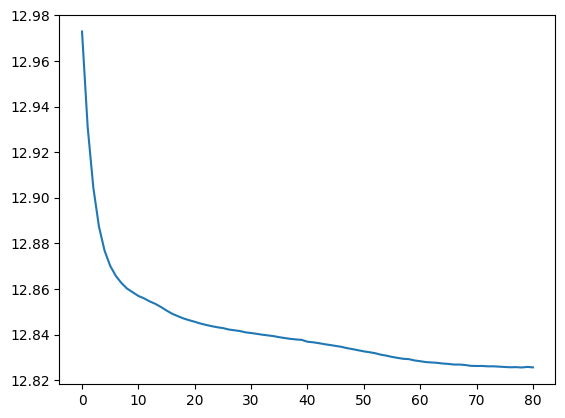

In [18]:
plt.plot(mean_loss_traj_train)

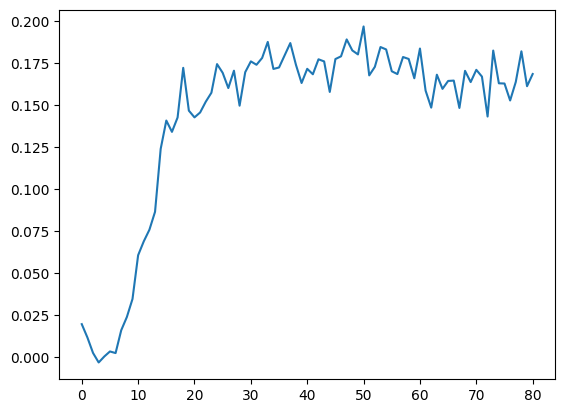

In [19]:
plt.plot(mean_corr_traj_val)